# **DATA3888 Project: Optiver**

In [3]:
import os
import pandas as pd
import dask.dataframe as dd

In [4]:
def load_data(directory: str) -> pd.DataFrame:

    all_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".csv"):
                all_files.append(os.path.join(root, file))

    if not all_files:
        raise FileNotFoundError("No CSV files found in the given directory.")

    df = dd.read_csv(all_files)
    return df.compute()

data_path = "./Data/individual_book_train"
df = load_data(data_path)

## **Data Exploration**

In [3]:
df.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.000129,1.000386,0.999871,1.000643,302,615,500,400,13
1,5,1,1.000129,1.000386,0.999871,1.000643,602,515,400,500,13
2,5,2,1.000129,1.000386,0.999871,1.000643,502,515,400,500,13
3,5,3,1.000129,1.000386,0.999871,1.000643,502,515,400,500,13
4,5,4,1.000129,1.000386,0.999871,1.000643,502,515,400,600,13


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167253289 entries, 0 to 962099
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   time_id            int64  
 1   seconds_in_bucket  int64  
 2   bid_price1         float64
 3   ask_price1         float64
 4   bid_price2         float64
 5   ask_price2         float64
 6   bid_size1          int64  
 7   ask_size1          int64  
 8   bid_size2          int64  
 9   ask_size2          int64  
 10  stock_id           int64  
dtypes: float64(4), int64(7)
memory usage: 15.0 GB


In [6]:
df.describe()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
count,1.672533e+08,1.672533e+08,1.672533e+08,1.672533e+08,1.672533e+08,1.672533e+08,1.672533e+08,1.672533e+08,1.672533e+08,1.672533e+08,1.672533e+08
mean,1.602237e+04,2.969969e+02,9.997121e-01,1.000283e+00,9.995184e-01,1.000479e+00,9.285549e+02,9.233744e+02,1.181631e+03,1.146534e+03,6.271922e+01
std,9.370937e+03,1.734195e+02,3.811545e-03,3.810885e-03,3.821979e-03,3.820810e-03,5.782958e+03,5.263738e+03,7.168244e+03,6.121242e+03,3.692018e+01
min,5.000000e+00,0.000000e+00,8.807735e-01,8.876458e-01,8.806137e-01,8.898833e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,7.837000e+03,1.460000e+02,9.984497e-01,9.989405e-01,9.982569e-01,9.991112e-01,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,3.200000e+01
50%,1.584500e+04,2.960000e+02,9.998062e-01,1.000211e+00,9.996398e-01,1.000380e+00,1.610000e+02,1.610000e+02,1.590000e+02,1.610000e+02,6.200000e+01
75%,2.395800e+04,4.470000e+02,1.001055e+00,1.001535e+00,1.000888e+00,1.001728e+00,4.000000e+02,3.970000e+02,5.000000e+02,5.000000e+02,9.500000e+01
max,3.276700e+04,5.990000e+02,1.125048e+00,1.127150e+00,1.124570e+00,1.127245e+00,1.051433e+06,6.462940e+05,9.801370e+05,8.501390e+05,1.260000e+02


In [7]:
df.isnull().sum()

time_id              0
seconds_in_bucket    0
bid_price1           0
ask_price1           0
bid_price2           0
ask_price2           0
bid_size1            0
ask_size1            0
bid_size2            0
ask_size2            0
stock_id             0
dtype: int64

## **Train-Test Split**

## **Feature Engineering**

In [8]:
def create_features(df):
    # --- Level 1 and Level 2 Price Features ---
    # Mid prices and spreads
    df['mid_price1'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['spread1'] = df['ask_price1'] - df['bid_price1']
    df['mid_price2'] = (df['bid_price2'] + df['ask_price2']) / 2
    df['spread2'] = df['ask_price2'] - df['bid_price2']
    
    # Relative spreads (spread as a fraction of mid price)
    df['relative_spread1'] = df['spread1'] / df['mid_price1']
    df['relative_spread2'] = df['spread2'] / df['mid_price2']
    
    # Price differences between levels
    df['bid_price_diff'] = df['bid_price1'] - df['bid_price2']
    df['ask_price_diff'] = df['ask_price2'] - df['ask_price1']
    df['mid_price_diff'] = df['mid_price1'] - df['mid_price2']
    
    # --- Order Size Features ---
    # Imbalance at each level (difference over sum)
    df['order_imbalance_level1'] = (df['bid_size1'] - df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['order_imbalance_level2'] = (df['bid_size2'] - df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    
    # Combined sizes and overall order imbalance
    df['total_bid_size'] = df['bid_size1'] + df['bid_size2']
    df['total_ask_size'] = df['ask_size1'] + df['ask_size2']
    df['total_order_imbalance'] = (df['total_bid_size'] - df['total_ask_size']) / (df['total_bid_size'] + df['total_ask_size'])
    
    # A weighted mid price for level 1 (using sizes as weights)
    df['weighted_mid_price1'] = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    
    # --- Additional Derived Features ---
    # Difference between the spreads of the two levels
    df['spread_diff'] = df['spread1'] - df['spread2']
    
    # --- Rolling (Temporal) Features ---
    # Make sure data is sorted by time; adjust window size as needed
    df = df.sort_values('time_id')
    window = 10  # Example window size
    df['rolling_mid_price1_mean'] = df['mid_price1'].rolling(window=window).mean()
    df['rolling_mid_price1_std'] = df['mid_price1'].rolling(window=window).std()
    df['rolling_spread1_mean'] = df['spread1'].rolling(window=window).mean()
    df['rolling_spread1_std'] = df['spread1'].rolling(window=window).std()
    
    return df

# Apply the feature engineering function
df_features = create_features(df)
print(df_features.head())

     time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  \
0          5                  0    1.000129    1.000386    0.999871   
482        5                537    1.005146    1.006134    1.004971   
483        5                538    1.005146    1.006192    1.005029   
484        5                539    1.005146    1.006192    1.005029   
485        5                540    1.005146    1.006308    1.005029   

     ask_price2  bid_size1  ask_size1  bid_size2  ask_size2  ...  \
0      1.000643        302        615        500        400  ...   
482    1.006192         25         25         28        257  ...   
483    1.006308         25        157        125         25  ...   
484    1.006425         25        100        125        125  ...   
485    1.006425         25         25        125        225  ...   

     order_imbalance_level2  total_bid_size  total_ask_size  \
0                  0.111111             802            1015   
482               -0.803509           

## **Plotting**

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_time_series_prices(df):
    """
    Plots time series of mid prices (calculated as the average of bid and ask).
    Helps visualize price trends and anomalies over time.
    """
    df_sorted = df.sort_values('time_id').copy()
    # Compute mid prices if not already available
    if 'mid_price1' not in df_sorted.columns:
        df_sorted['mid_price1'] = (df_sorted['bid_price1'] + df_sorted['ask_price1']) / 2
        df_sorted['mid_price2'] = (df_sorted['bid_price2'] + df_sorted['ask_price2']) / 2
    plt.figure(figsize=(12, 6))
    plt.plot(df_sorted['time_id'], df_sorted['mid_price1'], label='Mid Price 1', alpha=0.7)
    plt.plot(df_sorted['time_id'], df_sorted['mid_price2'], label='Mid Price 2', alpha=0.7)
    plt.xlabel('Time ID')
    plt.ylabel('Price')
    plt.title('Time Series of Mid Prices')
    plt.legend()
    plt.show()

def plot_time_series_order_imbalance(df):
    """
    Plots time series of order imbalance.
    Shows market pressure by plotting level-1 and overall (total) order imbalance over time.
    """
    df_sorted = df.sort_values('time_id').copy()
    # Compute order imbalances if not already available
    if 'order_imbalance_level1' not in df_sorted.columns:
        df_sorted['order_imbalance_level1'] = (df_sorted['bid_size1'] - df_sorted['ask_size1']) / (df_sorted['bid_size1'] + df_sorted['ask_size1'])
    if 'total_order_imbalance' not in df_sorted.columns:
        df_sorted['total_bid_size'] = df_sorted['bid_size1'] + df_sorted['bid_size2']
        df_sorted['total_ask_size'] = df_sorted['ask_size1'] + df_sorted['ask_size2']
        df_sorted['total_order_imbalance'] = (df_sorted['total_bid_size'] - df_sorted['total_ask_size']) / (df_sorted['total_bid_size'] + df_sorted['total_ask_size'])
    plt.figure(figsize=(12, 6))
    plt.plot(df_sorted['time_id'], df_sorted['order_imbalance_level1'], label='Level 1 Imbalance', alpha=0.7)
    plt.plot(df_sorted['time_id'], df_sorted['total_order_imbalance'], label='Total Order Imbalance', alpha=0.7)
    plt.xlabel('Time ID')
    plt.ylabel('Order Imbalance')
    plt.title('Time Series of Order Imbalance')
    plt.legend()
    plt.show()

def plot_histograms(df):
    """
    Plots histograms for all numeric features (excluding time_id) to inspect their distributions.
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != 'time_id']
    n_cols = 3
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))
    plt.figure(figsize=(15, n_rows * 4))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        plt.hist(df[col].dropna(), bins=50, alpha=0.7)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def plot_boxplots(df):
    """
    Plots boxplots for numeric features (excluding time_id) to detect outliers.
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != 'time_id']
    n_cols = 3
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))
    plt.figure(figsize=(15, n_rows * 4))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        plt.boxplot(df[col].dropna(), vert=True)
        plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

def plot_scatter_relationships(df):
    """
    Creates scatter plots for selected feature pairs to explore their relationships.
    Useful for detecting linearity, clusters, or anomalies.
    """
    df = df.copy()
    # Ensure key features exist
    if 'mid_price1' not in df.columns:
        df['mid_price1'] = (df['bid_price1'] + df['ask_price1']) / 2
    if 'weighted_mid_price1' not in df.columns:
        df['weighted_mid_price1'] = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    # Define pairs to plot
    pairs = [
        ('bid_price1', 'ask_price1'),
        ('bid_price2', 'ask_price2'),
        ('mid_price1', 'weighted_mid_price1'),
        ('bid_size1', 'ask_size1')
    ]
    # Optionally, plot total order imbalance vs mid_price1 if available
    if 'total_order_imbalance' in df.columns:
        pairs.append(('total_order_imbalance', 'mid_price1'))
    
    n_pairs = len(pairs)
    plt.figure(figsize=(6 * n_pairs, 5))
    for i, (x, y) in enumerate(pairs, 1):
        plt.subplot(1, n_pairs, i)
        plt.scatter(df[x], df[y], alpha=0.5, s=1)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(f'{x} vs {y}')
    plt.tight_layout()
    plt.show()

def plot_scatter_matrix(df):
    """
    Plots a scatter matrix for all numeric features.
    This provides a comprehensive view of pairwise relationships.
    """
    from pandas.plotting import scatter_matrix
    numeric_df = df.select_dtypes(include=[np.number])
    plt.figure(figsize=(15, 15))
    scatter_matrix(numeric_df, alpha=0.5, figsize=(15, 15), diagonal='hist')
    plt.suptitle('Scatter Matrix of Numeric Features')
    plt.show()

def plot_correlation_heatmap(df):
    """
    Plots a correlation heatmap of numeric features.
    Helps to quickly identify strong correlations that might guide feature selection.
    """
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr()
    plt.figure(figsize=(12, 10))
    plt.imshow(corr, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()

def plot_rolling_statistics(df, feature, window=50):
    """
    Plots the original feature along with its rolling mean and rolling standard deviation.
    Useful for understanding local trends and volatility.
    """
    df_sorted = df.sort_values('time_id').copy()
    rolling_mean = df_sorted[feature].rolling(window=window).mean()
    rolling_std = df_sorted[feature].rolling(window=window).std()
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_sorted['time_id'], df_sorted[feature], label=f'{feature}', alpha=0.5)
    plt.plot(df_sorted['time_id'], rolling_mean, label=f'Rolling Mean ({window})', color='red')
    plt.plot(df_sorted['time_id'], rolling_std, label=f'Rolling Std ({window})', color='green')
    plt.xlabel('Time ID')
    plt.ylabel(feature)
    plt.title(f'Rolling Statistics for {feature}')
    plt.legend()
    plt.show()

def plot_autocorrelation(df, feature):
    """
    Plots the autocorrelation of a given feature.
    Helps identify time dependencies, which is key for time-series forecasting.
    """
    from pandas.plotting import autocorrelation_plot
    plt.figure(figsize=(10, 5))
    autocorrelation_plot(df[feature].dropna())
    plt.title(f'Autocorrelation of {feature}')
    plt.show()

def plot_lag(df, feature):
    """
    Creates a lag plot for a given feature.
    Useful for visualizing autocorrelation and potential periodic patterns.
    """
    from pandas.plotting import lag_plot
    plt.figure(figsize=(6, 6))
    lag_plot(df[feature].dropna())
    plt.title(f'Lag Plot of {feature}')
    plt.show()

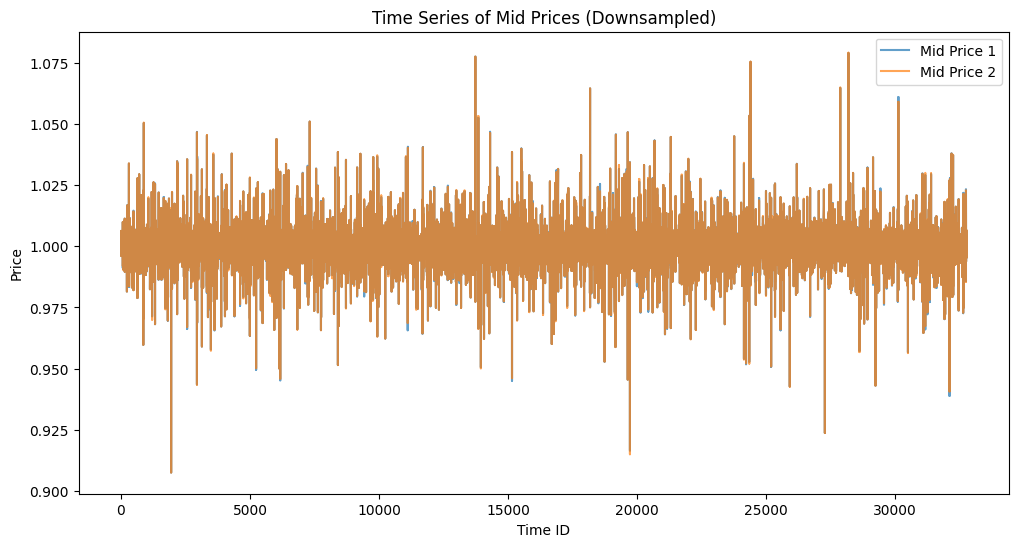

In [ ]:
def plot_time_series_prices_sampled(df, sample_rate=1000):
    df_sorted = df.sort_values('time_id').copy()
    # Ensure mid prices exist
    if 'mid_price1' not in df_sorted.columns:
        df_sorted['mid_price1'] = (df_sorted['bid_price1'] + df_sorted['ask_price1']) / 2
    if 'mid_price2' not in df_sorted.columns:
        df_sorted['mid_price2'] = (df_sorted['bid_price2'] + df_sorted['ask_price2']) / 2
        
    # Downsample
    df_sampled = df_sorted.iloc[::sample_rate, :]
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_sampled['time_id'], df_sampled['mid_price1'], label='Mid Price 1', alpha=0.7)
    plt.plot(df_sampled['time_id'], df_sampled['mid_price2'], label='Mid Price 2', alpha=0.7)
    plt.xlabel('Time ID')
    plt.ylabel('Price')
    plt.title('Time Series of Mid Prices (Downsampled)')
    plt.legend()
    plt.show()

plot_time_series_prices_sampled(df, sample_rate=1000)


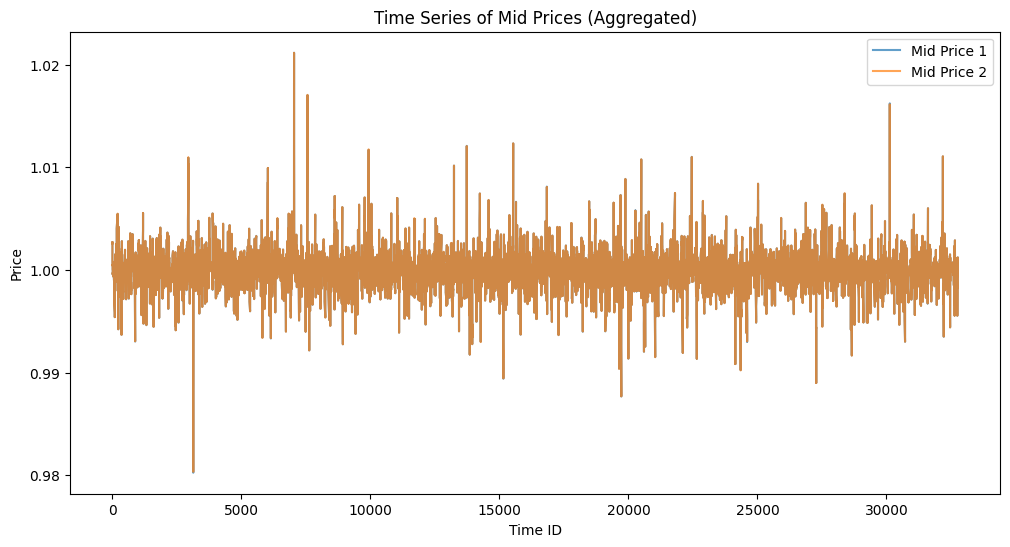

In [9]:
def plot_time_series_prices_aggregated(df, window_size=10000):
    df_sorted = df.sort_values('time_id').copy()
    # Create mid prices if they don't exist
    if 'mid_price1' not in df_sorted.columns:
        df_sorted['mid_price1'] = (df_sorted['bid_price1'] + df_sorted['ask_price1']) / 2
    if 'mid_price2' not in df_sorted.columns:
        df_sorted['mid_price2'] = (df_sorted['bid_price2'] + df_sorted['ask_price2']) / 2
        
    # Create a grouping key based on the window_size
    df_sorted['group'] = (np.arange(len(df_sorted)) // window_size)
    aggregated = df_sorted.groupby('group').agg({
        'time_id': 'first',
        'mid_price1': 'mean',
        'mid_price2': 'mean'
    }).reset_index()
    
    plt.figure(figsize=(12, 6))
    plt.plot(aggregated['time_id'], aggregated['mid_price1'], label='Mid Price 1', alpha=0.7)
    plt.plot(aggregated['time_id'], aggregated['mid_price2'], label='Mid Price 2', alpha=0.7)
    plt.xlabel('Time ID')
    plt.ylabel('Price')
    plt.title('Time Series of Mid Prices (Aggregated)')
    plt.legend()
    plt.show()

plot_time_series_prices_aggregated(df, window_size=10000)